<a href="https://colab.research.google.com/github/tsiligardi/PRA3024-Analysis-of-big-data-in-physics/blob/main/GWDA_Ex_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**PROBLEM 2**


In [1]:
import sys
!{sys.executable} -m pip install lalsuite pycbc


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
#Mounting drive on colab
#if not working on colab, ignore this part
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#Import the usefull libraries
%matplotlib inline
import pylab
import lal
from pycbc.filter import highpass,matched_filter
from pycbc.conversions import mass1_from_mchirp_q
from pycbc.catalog import Merger
from pycbc.frame import read_frame
from pycbc.filter import resample_to_delta_t, highpass
import numpy as np
from pycbc import types
from pycbc.waveform import get_td_waveform
from pycbc.waveform import td_approximants, fd_approximants
import pycbc.psd
from pycbc.psd import interpolate


In [4]:
#Problem 2
#first download the data from the assignament 

'''
Loading the data and converting the data type into time series
'''
d = np.load('/content/drive/MyDrive/noise_ts_4096Hz.npy') #name of the data file noise_ts_4096Hz.npy
#Note that this import assume that the file with the date is imported in drive and you are working on colab
dt = d[:, 0]
d = types.TimeSeries(d[:, 1], delta_t = dt[1]- dt[0]) #this is to comvert data into GW timeSeries
data = d

**Part 1**
<br>plot the noise power spectral
density (PSD) of that data. Test whether there is any gravitational wave signal present
in the data or not? For this test, you can assume the GW signals can produce only
from equal mass binary systems with a range between 5 to 10. We assume a threshold
on matched filter SNR of 8 to claim detection of GW

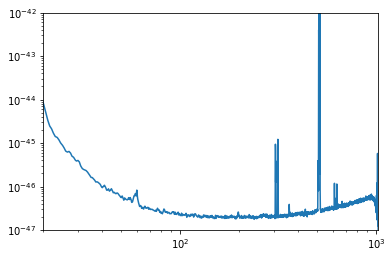

In [5]:
#getting strain and stilde from the data
strain=resample_to_delta_t(highpass(data, 15.0), 1.0/2048).crop(4,4)#applying an high pass filter and downsampling
stilde=strain.to_frequencyseries()
#Calcularing the power spectral density
delta_t = strain.delta_t
seg_len = int(2 / delta_t)
seg_stride = int(seg_len / 2) #how much overlapping of the segments
psds  = pycbc.psd.welch(strain,#power spectral density
                  seg_len=seg_len,
                  seg_stride=seg_stride)

psds = interpolate(psds, stilde.delta_f)

pylab.loglog(psds.sample_frequencies, psds, );
pylab.xlim(20, 1024);
pylab.ylim(1e-47, 1e-42);

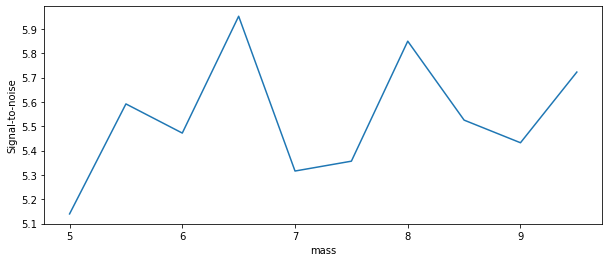

In [6]:
#Now I can determine the SNR. 
mass1 = np.arange(5, 10,0.5 ) #I am aware it is not a big range, but the calculation is pretty lengthy and in this way I can speed it up a bit
mass2 = mass1
Snr_list = []
for m in mass1:
  hp, hc = get_td_waveform(approximant="TaylorT2", #generating the waveform
                     mass1=m,
                     mass2=m,
                     delta_t=strain.delta_t,
                     f_lower=15.0)
  hp.resize(len(strain))#resizing
  template = hp.cyclic_time_shift(hp.start_time)#creating the template
    
  snr = matched_filter(template, strain,
                    psd=psds, low_frequency_cutoff=15.0)#Determine the snr
  snr_H1 = snr.crop(4 + 4, 4)


  Snr_list.append(max(abs(snr_H1)))#append the snr to the list


pylab.figure(figsize=[10, 4])
pylab.plot(mass1,Snr_list)
pylab.ylabel('Signal-to-noise')
pylab.xlabel('mass')
pylab.show()
  

From the graph we can see that SNR<8. Therefore, we can state that there is no signal in our data

**Part 2**
<br>Whiten the above data using its noise PSD. You can use PyCBC based function of the
Welch method to estimate the PSD. Construct a histogram of the whitened data and
show that the whiten data follows a Gaussian distribution with zero mean.

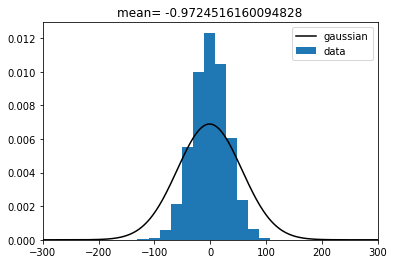

In [27]:
import scipy
from scipy.stats import norm
#whitening the data
white_data=(strain.to_frequencyseries()/psds**0.5).to_timeseries()
limits=(-300,300)#setting the limits of the histogram
#Fitting the data to a normal distribution
mean,sd=norm.fit(white_data)
#creating the gaussian
x=np.linspace(*limits,300)
gauss=norm.pdf(x,mean,sd)
#plotting --fix the plotting (or the fitting)
pylab.plot(x,gauss,'k',label='gaussian');
y=pylab.hist(white_data,bins=300,density=True,label='data')
pylab.xlim(*limits);
pylab.legend();
pylab.title("mean= {}".format(mean));


The mean is not exactly 0 as expected, however it is close enough to if (-0.9)

**Part 3**
<br>In gravitational wave data analysis, we consider that the noise is stationary Gaussian.
But in reality, the stationary assumption does not hold. Can you think of a test to
show that the stationarity does not hold?